In [195]:
import pandas as pd
import sqlite3


In [298]:
def return_table(begin_date2, end_date2):
    # Set up sqlite
    connection = sqlite3.connect('../static/data/sensors_readings_2016_present.db')
    
    # Assemble Query with proper placement of WHERE clause and using parameterized queries
    sql_query = """
    SELECT sensor_id, latitude, longitude, altitude, AVG(pm2) AS avg_pm2, AVG(pm10) AS avg_pm10
    FROM sensors_readings
    WHERE (date BETWEEN ? AND ?)
    GROUP BY sensor_id, latitude, longitude, altitude
    """
    
    # Execute the query with parameter substitution to prevent SQL injection
    df = pd.read_sql_query(sql_query, connection, params=(begin_date2, end_date2))
    
    connection.close()
    return df

In [299]:
df = return_table('2023-09-27','2023-09-30')
df

,sensor_id,latitude,longitude,altitude,avg_pm2,avg_pm10
0,77,40.750816,-111.825290,NaN,17.717333,17.952000
1,443,41.224422,-111.968376,NaN,6.603000,7.290167
2,525,40.783870,-111.870140,4891.0,0.902167,1.161167
3,984,40.595387,-111.807755,NaN,1.848500,2.114833
4,3238,40.664246,-111.849230,4331.0,3.000167,3.461167
...,...,...,...,...,...,...
195,169779,40.769947,-111.847015,4758.0,1.978167,2.797833
196,169851,40.902760,-111.872420,4361.0,2.419000,3.307500
197,169867,40.871600,-111.903200,4306.0,2.413000,3.527167
198,174555,40.722404,-111.823616,4621.0,1.970000,2.423667


In [272]:
df_color = pd.read_csv('../static/data/sensor_categories.csv')
df = pd.merge(df,df_color, on = 'sensor_id')

In [273]:
df

,sensor_id,latitude,longitude,altitude,avg_pm2,avg_pm10,category,county
0,77,40.750816,-111.825290,NaN,17.717333,17.952000,red,Salt Lake County
1,443,41.224422,-111.968376,NaN,6.603000,7.290167,red,Weber County
2,525,40.783870,-111.870140,4891.0,0.902167,1.161167,green,Salt Lake County
3,984,40.595387,-111.807755,NaN,1.848500,2.114833,blue,Salt Lake County
4,3238,40.664246,-111.849230,4331.0,3.000167,3.461167,blue,Salt Lake County
...,...,...,...,...,...,...,...,...
195,169779,40.769947,-111.847015,4758.0,1.978167,2.797833,red,Salt Lake County
196,169851,40.902760,-111.872420,4361.0,2.419000,3.307500,orange,Davis County
197,169867,40.871600,-111.903200,4306.0,2.413000,3.527167,blue,Davis County
198,174555,40.722404,-111.823616,4621.0,1.970000,2.423667,blue,Salt Lake County


In [274]:
# Compute category averages within each county
averages = df.groupby(['county', 'category']).mean().reset_index()
averages = averages[['county', 'category', 'avg_pm2', 'avg_pm10']]
averages.rename(columns={'avg_pm2': 'cat_avg_pm2', 'avg_pm10': 'cat_avg_pm10'}, inplace=True)
averages['cat_avg_pm2'] = round(averages['cat_avg_pm2']).astype('int')
averages['cat_avg_pm10'] = round(averages['cat_avg_pm10']).astype('int')

# Prepare the main DataFrame for merging
df['avg_pm2'] = round(df['avg_pm2']).astype('int')
df['avg_pm10'] = round(df['avg_pm10']).astype('int')

# Merge, using both 'county' and 'category' as keys
df = pd.merge(df, averages, on=['county', 'category'], suffixes=('', '_avg'))

In [275]:
df.loc[df['sensor_id'] == 77]

,sensor_id,latitude,longitude,altitude,avg_pm2,avg_pm10,category,county,cat_avg_pm2,cat_avg_pm10
0,77,40.750816,-111.82529,NaN,18,18,red,Salt Lake County,669,670


In [276]:
selected_colors =['red','orange','green','yellow']
df.loc[df['category'].isin(selected_colors)]

,sensor_id,latitude,longitude,altitude,avg_pm2,avg_pm10,category,county,cat_avg_pm2,cat_avg_pm10
0,77,40.750816,-111.825290,NaN,18,18,red,Salt Lake County,669,670
1,443,41.224422,-111.968376,NaN,7,7,red,Weber County,5,6
2,525,40.783870,-111.870140,4891.0,1,1,green,Salt Lake County,51,51
5,3388,40.733440,-111.821510,4715.0,0,0,green,Salt Lake County,51,51
7,5174,41.172134,-111.923890,5188.0,2,2,green,Weber County,240,240
...,...,...,...,...,...,...,...,...,...,...
190,156037,40.722088,-111.818810,4698.0,2,3,orange,Salt Lake County,166,166
191,156623,40.746613,-111.847490,4598.0,1,1,green,Salt Lake County,51,51
195,169779,40.769947,-111.847015,4758.0,2,3,red,Salt Lake County,669,670
196,169851,40.902760,-111.872420,4361.0,2,3,orange,Davis County,6,6


In [240]:
df_color.category.unique()

array(['red', 'yellow', 'green', 'orange'], dtype=object)

In [56]:
# Convert the date column to datetime
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')

# Now you can sort by this column
df_sorted = df.sort_values(by='date')

In [60]:
df_sorted.groupby('date').count().reset_index()[['date']].to_csv('date_range.csv', index=False)

In [319]:
def return_county(begin_date, end_date,red,orange,green,lightBlue):
    # Set up sqlite
    connection = sqlite3.connect('../static/data/sensors_readings_2016_present.db')
    
    # Assemble Query with proper placement of WHERE clause and using parameterized queries
    sql_query = """
    SELECT sensor_id, latitude, longitude, altitude, AVG(pm2) AS avg_pm2, AVG(pm10) AS avg_pm10
    FROM sensors_readings
    WHERE (date BETWEEN ? AND ?)
    GROUP BY sensor_id, latitude, longitude, altitude
    """
    
    # Execute the query with parameter substitution to prevent SQL injection
    df = pd.read_sql_query(sql_query, connection, params=(begin_date, end_date))
    
    connection.close()
    
    # Join with color categories
    df_color = pd.read_csv('../static/data/sensor_categories.csv')
    df = pd.merge(df,df_color, on = 'sensor_id')
    
    selected_colors =[]
    if red == True:
        selected_colors.append('red')
    if orange == True:
        selected_colors.append('orange')
    if green == True:
        selected_colors.append('green')
    if lightBlue == True:
        selected_colors.append('blue')
    
    df = df.loc[df['category'].isin(selected_colors)]
    
    df.drop(['category'], axis=1, inplace=True)
    # Get category averages
    averages = df.groupby('county').mean().reset_index()
    averages = averages[['county','avg_pm2','avg_pm10']]
    averages.rename(columns = {'avg_pm2':'cat_avg_pm2','avg_pm10':'cat_avg_pm10'}, inplace = True)
    averages['cat_avg_pm2'] = round(averages['cat_avg_pm2']).astype('int')
    averages['cat_avg_pm10'] = round(averages['cat_avg_pm10']).astype('int')
    
    # Join
    
    df['avg_pm2'] = round(df['avg_pm2']).astype('int')
    df['avg_pm10'] = round(df['avg_pm10']).astype('int')

    df = pd.merge(df,averages, on = 'county')
    df = pd.merge(df,df_color, on = ['sensor_id','county'])
    
    return df

In [320]:
df = return_county('2023-09-27','2023-09-30',True,True,True,True)
df.cat_avg_pm2.unique()

array([131, 241, 141])

In [321]:
df

,sensor_id,latitude,longitude,altitude,avg_pm2,avg_pm10,county,cat_avg_pm2,cat_avg_pm10,category
0,77,40.750816,-111.825290,4870,18,18,Salt Lake County,131,132,red
1,443,41.224422,-111.968376,4565,7,7,Weber County,241,241,red
2,525,40.783870,-111.870140,4891,1,1,Salt Lake County,131,132,green
3,984,40.595387,-111.807755,5149,2,2,Salt Lake County,131,132,blue
4,3238,40.664246,-111.849230,4331,3,3,Salt Lake County,131,132,blue
...,...,...,...,...,...,...,...,...,...,...
178,165997,40.733875,-111.841090,4561,2,3,Salt Lake County,131,132,blue
179,168215,40.677616,-111.834690,4458,2,3,Salt Lake County,131,132,blue
180,169779,40.769947,-111.847015,4758,2,3,Salt Lake County,131,132,red
181,169851,40.902760,-111.872420,4361,2,3,Davis County,141,141,orange


In [300]:
2+2

4

In [314]:
df_color

,sensor_id,category,county
0,77,red,Salt Lake County
1,443,red,Weber County
2,525,green,Salt Lake County
3,984,blue,Salt Lake County
4,992,green,Salt Lake County
...,...,...,...
217,204009,red,Salt Lake County
218,204315,green,Salt Lake County
219,207743,blue,Salt Lake County
220,208781,green,Weber County


In [365]:
def return_county(begin_date, end_date,red,orange,green,lightBlue,salt,web,dav):
    # Set up sqlite
    connection = sqlite3.connect('../static/data/sensors_readings_2016_present.db')
    
    # Assemble Query
    sql_query = """
    SELECT sensor_id, latitude, longitude, altitude, AVG(pm2) AS avg_pm2, AVG(pm10) AS avg_pm10
    FROM sensors_readings
    WHERE date(date) BETWEEN ? AND ?
    GROUP BY sensor_id, latitude, longitude, altitude
    """
    
    # Execute the query
    df = pd.read_sql_query(sql_query, connection, params=(begin_date, end_date))
    
    # Join with color categories
    df_color = pd.read_csv('../static/data/sensor_categories.csv')
    df = pd.merge(df,df_color, on = 'sensor_id')
    df.drop(['category'], axis=1, inplace=True)
    # Get category averages
    averages = df.groupby('county').mean().reset_index()
    averages = averages[['county','avg_pm2','avg_pm10']]
    averages.rename(columns = {'avg_pm2':'cat_avg_pm2','avg_pm10':'cat_avg_pm10'}, inplace = True)
    averages['cat_avg_pm2'] = round(averages['cat_avg_pm2']).astype('int')
    averages['cat_avg_pm10'] = round(averages['cat_avg_pm10']).astype('int')
    
    # Join
    
    df['avg_pm2'] = round(df['avg_pm2']).astype('int')
    df['avg_pm10'] = round(df['avg_pm10']).astype('int')

    df = pd.merge(df,averages, on = 'county')
         
    
    selected_counties =[]
    if salt == True:
        selected_counties.append('Salt Lake County')
    if web == True:
        selected_counties.append('Weber County')
    if dav == True:
        selected_counties.append('Davis County')
                 
    
    df = df.loc[df['county'].isin(selected_counties)]
    df = pd.merge(df,df_color, on = ['sensor_id','county'])
    
    selected_colors =[]
    if red == True:
        selected_colors.append('red')
    if orange == True:
        selected_colors.append('orange')
    if green == True:
        selected_colors.append('green')
    if lightBlue == True:
        selected_colors.append('blue')
    
    df = df.loc[df['category'].isin(selected_colors)].reset_index()
    
    connection.close()
    return df
    

In [388]:
df = return_table('2023-09-27','2023-09-30',True,True,True,True,True,True,True)
df.avg_pm10.mean()
df.head()

,sensor_id,latitude,longitude,altitude,avg_pm2,avg_pm10,category,cat_avg_pm2,cat_avg_pm10,county
0,77,40.750816,-111.825290,4870,18,18,red,644,644,Salt Lake County
1,443,41.224422,-111.968376,4565,7,8,red,644,644,Weber County
2,525,40.783870,-111.870140,4891,1,1,green,117,117,Salt Lake County
3,984,40.595387,-111.807755,5149,2,2,blue,56,57,Salt Lake County
4,3238,40.664246,-111.849230,4331,3,3,blue,56,57,Salt Lake County


### 

In [441]:
def sensor_linear(begin_date,end_date, the_sensor):
    connection = sqlite3.connect('../static/data/sensors_readings_2016_present.db')
    
    # Assemble Query
    sql_query = """
    SELECT pm2
    FROM sensors_readings
    where (date(date) between ? and ?) and (sensor_id = ?)
    """
    
    #df = pd.read_sql_query(sql_query, connection, params=(begin_date, end_date))
    df = pd.read_sql_query(sql_query, connection, params=(begin_date,end_date,the_sensor))
    connection.close()
    
    return df

In [442]:
df=sensor_linear('2020-01-01','2020-09-30','443')
df

,pm2
0,13.4670
1,12.3160
2,11.9890
3,12.5715
4,15.9195
...,...
227,10.1300
228,9.2255
229,14.0900
230,13.5300


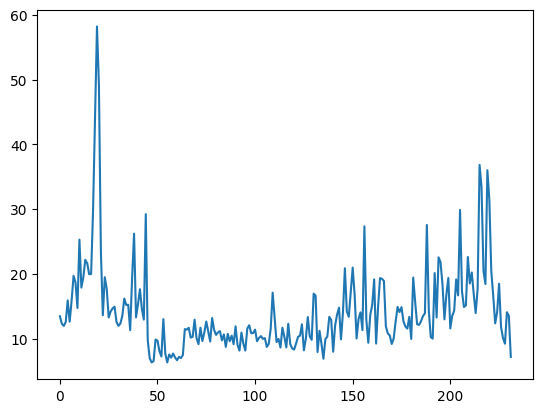

In [411]:
import matplotlib.pyplot as plt


plt.plot(df.pm2)

In [428]:
def sensors_pandemic(begin_date,end_date):
    connection = sqlite3.connect('../static/data/sensors_readings_2016_present.db')
    # Assemble Query
    sql_query = """
    SELECT date, avg(pm2) as avg_pm2,avg(pm10) as avg_pm10
    FROM sensors_readings
    where (date(date) between ? and ?) 
    group by date
    
    """
    
    #df = pd.read_sql_query(sql_query, connection, params=(begin_date, end_date))
    df = pd.read_sql_query(sql_query, connection, params=(begin_date,end_date))
    connection.close()
    
    return df

In [439]:
df=sensors_pandemic('2016-11-01','2021-01-01')

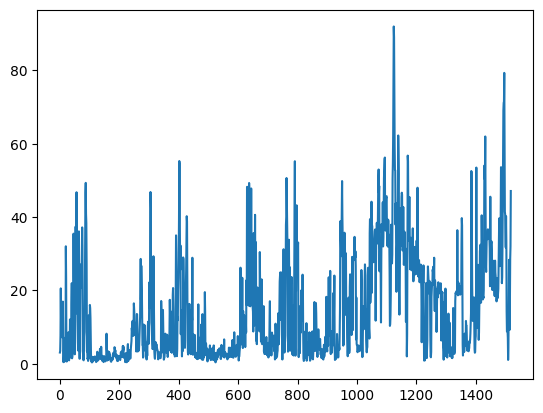

In [440]:
plt.plot(df.avg_pm2)

In [451]:
# today

def return_today(begin_date2, end_date2):
    # Set up sqlite
    connection = sqlite3.connect('../static/data/sensors_readings_2016_present.db')
    
    # Assemble Query with proper placement of WHERE clause and using parameterized queries
    sql_query = """
    SELECT *
    FROM sensors_readings
    WHERE (date BETWEEN ? AND ?)
    GROUP BY sensor_id, latitude, longitude, altitude
    """
    
    # Execute the query with parameter substitution to prevent SQL injection
    df = pd.read_sql_query(sql_query, connection, params=(begin_date2, end_date2))
    
    connection.close()
    return df

df_today = return_today('2024-03-01','2024-03-02')

In [453]:
df_today.to_csv('../static/data/today_air.csv')

In [455]:
# Load your CSV data into a DataFrame
url = '../static/data/today_air.csv'
df = pd.read_csv(url)

# Connect to a SQLite memory database
connection = sqlite3.connect(':memory:')

# Write the data to SQLite
df.to_sql('today_air', connection, index=False, if_exists='replace')

# Now you can query your data
query = "SELECT * FROM today_air"
result_df = pd.read_sql_query(query, connection)

# Use your result_df as needed
print(result_df)

# Close the connection when done
connection.close()


     Unnamed: 0  sensor_id   latitude   longitude                 date  \
0             0         77  40.750816 -111.825290  2024-03-01 00:00:00   
1             1        443  41.224422 -111.968376  2024-03-01 00:00:00   
2             2        525  40.783870 -111.870140  2024-03-01 00:00:00   
3             3        984  40.595387 -111.807755  2024-03-01 00:00:00   
4             4        992  40.727630 -111.824425  2024-03-01 00:00:00   
..          ...        ...        ...         ...                  ...   
189         189     169779  40.769947 -111.847015  2024-03-01 00:00:00   
190         190     169851  40.902760 -111.872420  2024-03-01 00:00:00   
191         191     169867  40.871600 -111.903200  2024-03-01 00:00:00   
192         192     199845  40.705555 -111.809586  2024-03-01 00:00:00   
193         193     204009  40.593708 -111.895250  2024-03-01 00:00:00   

     altitude      pm2     pm10  
0        4870  19.4370  19.8530  
1        4565   7.9010   8.7440  
2        

In [ ]:
from datetime import datetime, timedelta

# Example dates
begin_date = "2024-03-27"
end_date = "2024-03-27"

# Convert strings to datetime objects
begin_date_obj = datetime.strptime(begin_date, "%Y-%m-%d")
end_date_obj = datetime.strptime(end_date, "%Y-%m-%d")

# Check if dates are the same
if begin_date_obj == end_date_obj:
    # Move end_date forward by one day
    end_date_obj += timedelta(days=1)

# Convert back to string if needed
end_date = end_date_obj.strftime("%Y-%m-%d")

end_date


In [467]:
def sensor_linear(begin_date,end_date, the_sensor):
    connection = sqlite3.connect('../static/data/sensors_readings_2016_present.db')
    
    # Assemble Query
    sql_query = """
    SELECT date(date) as theDate, pm2
    FROM sensors_readings
    where (date(date) between ? and ?) and (sensor_id = ?)
    order by date asc
    """
    
    #df = pd.read_sql_query(sql_query, connection, params=(begin_date, end_date))
    df = pd.read_sql_query(sql_query, connection, params=(begin_date,end_date,the_sensor))
    connection.close()
    
    return df

In [468]:
df_today = sensor_linear('2024-03-01','2024-03-02','77')

In [469]:
df_today

,theDate,pm2
0,2024-03-01,19.437
1,2024-03-02,23.956


In [500]:
from tensorflow.keras.models import load_model
import numpy as np

model = load_model('../static/data/test_model.h5')

In [511]:
input_value = np.array([[10],[20]])
prediction = model.predict(input_value)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [513]:
input_value = np.array([[10]])
prediction = model.predict(input_value)

TypeError: type numpy.ndarray doesn't define __round__ method

In [527]:
model = load_model('../static/data/test_model.h5')


def predict_AQ():
    #data = request.get_json(force=True)
    
    pm2 = 10
    pm10 = 20


    prediction = np.round(model.predict(input_value))
  
 
   
    # Return the prediction as a JSON response
    return jsonify(prediction.tolist())

In [528]:
predict_AQ()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


RuntimeError: Working outside of application context.

This typically means that you attempted to use functionality that needed
the current application. To solve this, set up an application context
with app.app_context(). See the documentation for more information.

In [537]:
import json
model = load_model('../static/data/test_model.h5')


def predict_AQ():
    # Retrieve values from request and convert them to float
    pm2 = 10.2
    pm10 = 11.2
    # lat = request.args.get('lat')
    # lng = request.args.get('lng')
    # Construct the input array with shape (1, 2)
    
    input_value = np.array([[pm2], [pm10]])

    # Predict and round the prediction
    prediction = np.round(model.predict(input_value))

    # Return the prediction as a JSON response
    return (prediction.tolist())

In [546]:
list(np.array(predict_AQ()).flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[8.0, 9.0]

In [565]:
def predict_AQ():
    # Retrieve values from request and convert them to float
    pm2 = 70.4
    pm10 = 10.2
#     lat = request.args.get('lat')
#     lng = request.args.get('lng')

#
    input_value = np.array([[pm2], [pm10]])
#
#    # Predict and round the prediction
    prediction = np.round(model.predict(input_value),0)
    prediction = list(np.array(prediction).flatten())

    # Return the prediction as a JSON response
    return prediction

In [566]:
a=predict_AQ()

2024-03-30 18:17:43.898776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Matrix size-incompatible: In[0]: [1,2], In[1]: [1,1]
	 [[{{node functional_39_1/dense_19_1/MatMul}}]]


InvalidArgumentError: Graph execution error:

Detected at node functional_39_1/dense_19_1/MatMul defined at (most recent call last):
  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/runpy.py", line 86, in _run_code

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/kn/v0dr_8xn1qj15xgwlhdyfzph0000gn/T/ipykernel_85165/1905951024.py", line 1, in <module>

  File "/var/folders/kn/v0dr_8xn1qj15xgwlhdyfzph0000gn/T/ipykernel_85165/351921312.py", line 12, in predict_AQ

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 515, in predict

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 213, in one_step_on_data_distributed

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 202, in one_step_on_data

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 94, in predict_step

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/keras/src/layers/layer.py", line 814, in __call__

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/keras/src/models/functional.py", line 194, in call

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/keras/src/ops/function.py", line 151, in _run_through_graph

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/keras/src/models/functional.py", line 578, in call

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/keras/src/layers/layer.py", line 814, in __call__

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/keras/src/layers/core/dense.py", line 142, in call

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/keras/src/ops/numpy.py", line 3555, in matmul

  File "/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/keras/src/backend/tensorflow/numpy.py", line 402, in matmul

Matrix size-incompatible: In[0]: [1,2], In[1]: [1,1]
	 [[{{node functional_39_1/dense_19_1/MatMul}}]] [Op:__inference_one_step_on_data_distributed_2472]

In [563]:
type(a)

list

In [564]:
b=[2,4]
type(b)

list